In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model

## Note:

we change a bit the input data, to get 2 dimensions for the input, to avoid troubles with matrix shapes (N,1) is different from (N,) in `python`, and this is often needlessly annoying.

So dimension 0 is trivial, dimension 1 is interesting, and there is a **bias** (which will be handled by using `fit_intercept=True`

In [2]:
X= np.array([1,2,3,4])
N=X.shape[0]
X = np.vstack((np.zeros(N), X)).T  #or, we could do :  X.reshape((N,1))  ## then you need to change the code for plots
wGT = np.array([0, 0.1])
D=X.shape[1]-1
y = X@wGT + 2
y[1] -= 0.1
y[2] += 0.1
y = y.reshape(-1,1)

(0.0, 3.0)

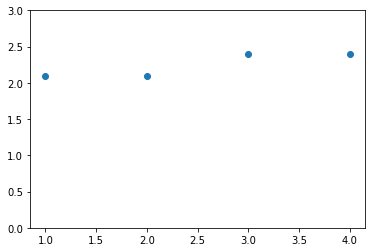

In [3]:
plt.scatter(X[:,1],y)
plt.ylim([0,3])

### Question 3 (of last time' tutorial) -- kept for reference
Learn the Lasso model, using the method  `sklearn.linear_model.Lasso`, and compare the results using alpha=1 or alpha=0.01.

In [4]:
#?sklearn.linear_model.Lasso

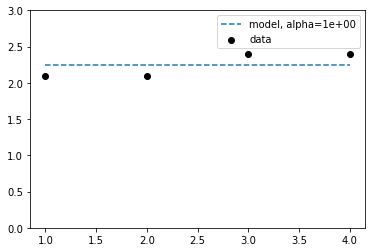

In [5]:
alpha=1
lasso1 = sklearn.linear_model.Lasso(alpha=alpha)
lasso1.fit(X,y)
prediction = lasso1.predict(X)
plt.scatter(X[:,1],y, label="data", c='k')
plt.plot(X[:,1], prediction, ls="--", label="model, alpha=%.e"%alpha)
plt.ylim([0,3])
plt.legend()

### Question 5: -- now we actually do it 
Code your own Lasso algorithm, using numpy (first, do the exercise on the Laplace prior) -- you may need sub-gradients.

## Now we actually do this "question 5", but split it in parts, to guide you

### Question 5.0 - unregularized regression

Here we give you the code, as an example to start.
It's very similar to the correction `TP3.2-FeatureMaps-Correction.ipynb`. You can use your own version if you prefer (you may have to adapt the rest of the code then)

In [6]:
class classLinearRegressorFullBatch():

    def __init__(self, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        self.eta = eta
        self.maxIter = maxIter
        self.seed = seed
        self.w = None # at the start, it's undefined
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((D,1))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y):
        ## the full-batch perceptron in its cleanest form
        ## or really we should call it LinearClassifier with least squares loss, rather than Perceptron
        
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) # exgtended vector, with 1's as first component
        D = X.shape[1]        
        w0 = self.initializeWeights(D)       
        wparameters = w0.copy()  # deep copy
        assert(y.shape[0]==N)

        trainLoss = np.zeros(self.maxIter)
        ## it's important to ALWAYS also follow the test error 
        ## BUT here we have only a toy model, so it doesn't matter much. We could put a noiseless ground truth as test data
        # testLoss = np.zeros(self.maxIter) 
        
        ## the algo itself ##
        for epoch in range(self.maxIter):
            tempo = (X@wparameters -y) ## array of shape (N,D)
            wparameters -= self.eta*(1./N)*(X.T @ tempo)
            trainLoss[epoch] = (tempo**2).sum()
            # testLoss[epoch] = ## not absolutely needed.
        self.w = wparameters
        return wparameters, trainLoss
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) 
        ypredicted = np.dot(X,self.w) ## np.sign() is NOT PRESENT here !
        return ypredicted
    
    def score(self, X, y):
        ypred = self.predict(X)
        difference = (ypred-y)
        diffsquared = (np.abs(difference)**2).sum()  ## DIFFERENCE HERE  !
        rateOfCorrectClassif = 1 - diffsquared*1.0/X.shape[0]
        return rateOfCorrectClassif
        
        

0.9954999999999464
[[1.94999943]
 [0.26022003]
 [0.12000019]]


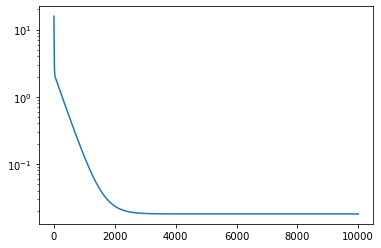

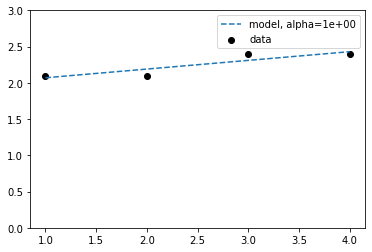

In [7]:
eta=0.01  # learning rate 
MaxIter = 10000
reg1 = classLinearRegressorFullBatch(eta=eta, seed=42, maxIter=MaxIter, fit_intercept=True) # order of parameters does not matter
w, trainLoss = reg1.fit(X,y)
print(reg1.score(X,y))
print(reg1.w)
plt.semilogy(trainLoss)

plt.figure()
prediction = reg1.predict(X)
plt.scatter(X[:,1],y, label="data", c='k')
plt.plot(X[:,1], prediction, ls="--", label="model, alpha=%.e"%alpha)
plt.ylim([0,3])
plt.legend()

### Question 5.1 - L2-regularized regression (Ridge)

To get started, you may code the Ridge regression, which, using GD, is trivial to implement.

We assume the regularization term comes as 

$$+ \frac{\alpha}{2} ||\vec w||_2^2,$$ where $\vec w$ is the vector of weights, without the bias term (when it is present).

In [8]:
class Ridge():

    def __init__(self, alpha = 0.01, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        self.alpha = alpha
        self.eta = eta
        self.maxIter = maxIter
        self.seed = seed
        self.w = None # at the start, it's undefined
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((D,1))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y):
        ## the full-batch perceptron in its cleanest form
        ## or really we should call it LinearClassifier with least squares loss, rather than Perceptron
        
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) # exgtended vector, with 1's as first component
        D = X.shape[1]        
        w0 = self.initializeWeights(D)       
        wparameters = w0.copy()  # deep copy
        assert(y.shape[0]==N)

        trainLoss = np.zeros(self.maxIter)
        ## it's important to ALWAYS also follow the test error 
        ## BUT here we have only a toy model, so it doesn't matter much. We could put a noiseless ground truth as test data
        # testLoss = np.zeros(self.maxIter) 
        
        ## the algo itself ##
        for epoch in range(self.maxIter):
            tempo = (X@wparameters -y) ## array of shape (N,D)
            
            wcopy_not_on_intyercept = wparameters.copy()
            if self.fit_intercept==True:
                wcopy_not_on_intyercept[0]=0            
            wparameters -= self.eta*(1./N)*(X.T @ tempo) + self.alpha*self.eta*1*wcopy_not_on_intyercept
            
            
            trainLoss[epoch] = (tempo**2).sum()
            # testLoss[epoch] = ## not absolutely needed.
        self.w = wparameters
        return wparameters, trainLoss
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) 
        ypredicted = np.dot(X,self.w) ## np.sign() is NOT PRESENT here !
        return ypredicted
    
    def score(self, X, y):
        ypred = self.predict(X)
        difference = (ypred-y)
        diffsquared = (np.abs(difference)**2).sum()  ## DIFFERENCE HERE  !
        rateOfCorrectClassif = 1 - diffsquared*1.0/X.shape[0]
        return rateOfCorrectClassif
        
        

0.9919444444466162
[[2.08333333e+00]
 [5.85176250e-45]
 [6.66666667e-02]]


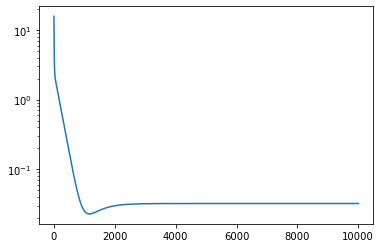

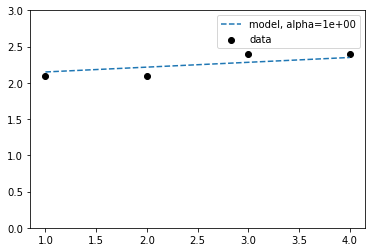

In [10]:
alpha = 1
eta = 0.01  # learning rate 
MaxIter = 10000
ridge1 = Ridge(alpha = alpha, eta=eta, maxIter=MaxIter, fit_intercept=True)
w, trainLoss = ridge1.fit(X,y)
print(ridge1.score(X,y))
print(ridge1.w)
plt.semilogy(trainLoss)

plt.figure()
prediction = ridge1.predict(X)
plt.scatter(X[:,1],y, label="data", c='k')
plt.plot(X[:,1], prediction, ls="--", label="model, alpha=%.e"%alpha)
plt.ylim([0,3])
plt.legend()

In [11]:
w

array([[2.08333333e+00],
       [5.85176250e-45],
       [6.66666667e-02]])

### Question 5.2 - L1-regularized regression (Lasso) -- Naive

To get started, you may code the Lasso regression naively, i.e. simply ignore the problems around $0$ and hope that everything goes well.

We assume the regularization term comes as 

$$+ \frac{\alpha}{2} ||\vec w||_1 =  \frac{\alpha}{2} \sum_{d=1}^D |w_d| ,$$ where $\vec w$ is the vector of weights, without the bias term $w_0$ (if it is present in the model).

Run it and observe the train loss as a function of the epoch number. Is the Loss converging to a well-defined value ? Why is that ?

Trick: plot also the last 100 values of trainLoss, rather than all of them

In [12]:
X

array([[0., 1.],
       [0., 2.],
       [0., 3.],
       [0., 4.]])

In [14]:
np.sign(X)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [15]:
class NaiveLasso():

    def __init__(self, alpha = 0.01, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        self.alpha = alpha
        self.eta = eta
        self.maxIter = maxIter
        self.seed = seed
        self.w = None # at the start, it's undefined
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        
    def initializeWeights(self,D):
        np.random.seed(self.seed)
        wparameters = (np.random.random((D,1))-0.5)/D**0.5
        return wparameters

    def fit(self, Xraw, y):
        ## the full-batch perceptron in its cleanest form
        ## or really we should call it LinearClassifier with least squares loss, rather than Perceptron
        
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) # exgtended vector, with 1's as first component
        D = X.shape[1]        
        w0 = self.initializeWeights(D)       
        wparameters = w0.copy()  # deep copy
        assert(y.shape[0]==N)

        trainLoss = np.zeros(self.maxIter)
        ## it's important to ALWAYS also follow the test error 
        ## BUT here we have only a toy model, so it doesn't matter much. We could put a noiseless ground truth as test data
        # testLoss = np.zeros(self.maxIter) 
        
        ## the algo itself ##
        for epoch in range(self.maxIter):
            tempo = (X@wparameters -y) ## array of shape (N,D)
            signTheta_not_on_intercept = np.sign(wparameters)
            if self.fit_intercept==True:
                signTheta_not_on_intercept[0]=0
            wparameters -= self.eta*(1./N)*(X.T @ tempo) + self.alpha*self.eta*2*signTheta_not_on_intercept
            trainLoss[epoch] = (tempo**2).sum()
            # testLoss[epoch] = ## not absolutely needed.
        self.w = wparameters
        return wparameters, trainLoss
    
    def predict(self,Xraw):
        N = Xraw.shape[0]
        if self.fit_intercept==False:
            X = Xraw
        else:
            X = np.hstack((np.ones((N,1)), Xraw)) 
        ypredicted = np.dot(X,self.w) ## np.sign() is NOT PRESENT here !
        return ypredicted
    
    def score(self, X, y):
        ypred = self.predict(X)
        difference = (ypred-y)
        diffsquared = (np.abs(difference)**2).sum()  ## DIFFERENCE HERE  !
        rateOfCorrectClassif = 1 - diffsquared*1.0/X.shape[0]
        return rateOfCorrectClassif
        
        

0.9809902957570475
[[ 2.24370288]
 [-0.01977997]
 [ 0.017891  ]]


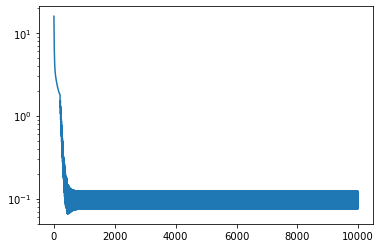

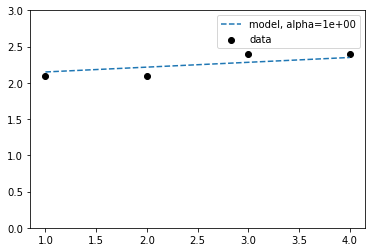

In [17]:
alpha = 1
eta=0.01  # learning rate 
MaxIter = 10000
lasso1 = NaiveLasso(alpha = alpha, eta=eta, maxIter=MaxIter, fit_intercept=True)
w, trainLoss = lasso1.fit(X,y)
print(lasso1.score(X,y))
print(lasso1.w)
plt.semilogy(trainLoss)

plt.figure()
prediction = ridge1.predict(X)
plt.scatter(X[:,1],y, label="data", c='k')
plt.plot(X[:,1], prediction, ls="--", label="model, alpha=%.e"%alpha)
plt.ylim([0,3])
plt.legend()

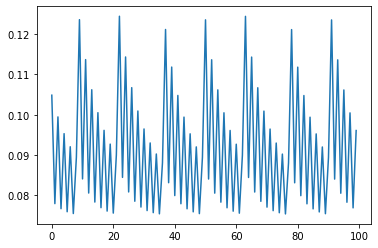

In [18]:
plt.plot(trainLoss[-100:])

### Answer:

the naive gradient cannot converge to exaclty 0. We have oscillations and are unable to converge to a well-defined value.

### Question 5.3 - L1-regularized regression (Lasso) -- CORRECT version

### This can take time, consider it as a bonus homework exercise

Now, getting inspired by the results obtained in the TD (exercise 3.4.b for instance), derive the proper gradient updates. 

Then write the correct Lasso regularization code, run it and check its convergence.

If you'r estuck, you may consult e.g. scikit-learn source code, `https://github.com/scikit-learn/scikit-learn/blob/1f8825c8dd6238355191e3d1c98f4e4d54cfbf16/sklearn/linear_model/_cd_fast.pyx` , lines ~160 and after.



In [14]:
class CorrectLasso():

    def __init__(self, alpha = 0.01, eta=0.001, maxIter=100, seed=42, verbose=True, fit_intercept=True):
        pass
        ## TODO 

In [15]:
# alpha = 0.5
# eta=0.01  # learning rate 
# MaxIter = 10000
# lasso1 = CorrectLasso(alpha = alpha, eta=eta, maxIter=MaxIter, fit_intercept=True)
# w, trainLoss = lasso1.fit(X,y)
# print(lasso1.score(X,y))
# print(lasso1.w)
# plt.semilogy(trainLoss)

# plt.figure()
# prediction = ridge1.predict(X)
# plt.scatter(X[:,1],y, label="data", c='k')
# plt.plot(X[:,1], prediction, ls="--", label="model, alpha=%.e"%alpha)
# plt.ylim([0,3])
# plt.legend()